In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [12]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [13]:
#onehot encode labels
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [14]:
print(X_test.shape)

(10000, 28, 28)


In [15]:
def place_image_on_canvas(image, width=1200, height=1200):
    """
    Place a single MNIST image at a random location on a blank canvas of given dimensions.
    """
    # Create a blank canvas
    canvas = np.zeros((height, width))

    # Image dimensions
    img_height, img_width = image.shape

    # Ensure the image fits: choose random coordinates for the top-left corner
    max_x, max_y = width - img_width, height - img_height
    x, y = np.random.randint(0, max_x), np.random.randint(0, max_y)

    # Place the image on the canvas
    canvas[y:y+img_height, x:x+img_width] = image

    return canvas, (x, y)


def create_dataset(list_img, list_labels, n_images=100):
    """
    Create a dataset of n_images of MNIST placed randomly on individual 1200x1200 canvases.
    """
    X = []
    #y = []
    coords_x = []
    coords_y = []
    labels = []
    for i in range(n_images):
        image = list_img[i]
        # Create a canvas with the image placed randomly
        canvas, (x, y) = place_image_on_canvas(image, width=128, height=128)
        canvas = canvas.reshape(128, 128, 1)
        #flat_canvas = canvas_norm.flatten()
        # Add the canvas to the dataset
        X.append(canvas)
        labels.append(list_labels[i])
        coords_x.append(x)
        coords_y.append(y)
    
    X = np.array(X)
    coords = np.array([coords_x, coords_y]).T
    #X = X.reshape(X.shape[0], 128, 128, 1)

    return X, coords, labels

In [16]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def example_test(image, label):
    feature = {
        'image': _bytes_feature(image),
        'label': _bytes_feature(label)
    }
    #print(f'feature: {feature["label"]}')
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_in_batches(data, filename, coords=True):
    with tf.io.TFRecordWriter(filename) as writer:
        for images, labels in data:
            # Serialize images and labels as tensors
            image_tesnor = tf.convert_to_tensor(images)
            print(image_tesnor.shape)
            
            serialized_image = tf.io.serialize_tensor(image_tesnor).numpy()
            #labels_unonehot = np.argmax(labels, axis=-1)  # Convert one-hot labels to class indices
            if coords:
              label_tensor = tf.convert_to_tensor(labels)
              #reshaped_tensor = tf.expand_dims(label_tensor, axis=-1)  # Adds a new dimension at the last axis
              print(label_tensor.shape)

              serialized_label = tf.io.serialize_tensor(label_tensor).numpy()
            else:
              label_tensor = tf.reshape(tf.convert_to_tensor(labels), [-1])
              reshaped_tensor = tf.expand_dims(label_tensor, axis=-1)  # Adds a new dimension at the last axis
              print(reshaped_tensor.shape)

              serialized_label = tf.io.serialize_tensor(reshaped_tensor).numpy()

            
            # Create tf.train.Example and write it to the file
            tf_example = example_test(serialized_image, serialized_label)
            writer.write(tf_example.SerializeToString())

In [17]:
def data_generator(x, y, batch_size=128):
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size]

def create_tf_dataset(x, y, batch_size=128, out_shape = (128, 10)):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(x, y, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(128,128,128,1), dtype=tf.float32),  # Adjust shape if needed
            tf.TensorSpec(shape=out_shape, dtype=tf.int32)  # Adjust shape if needed
        )
    )
    return dataset

In [18]:
X_train_canvas, coords, y_train = create_dataset(X_train, y_train, n_images=896) #59904
X_test_canvas, coords_test, y_test = create_dataset(X_test, y_test, n_images=896) #9984

In [19]:
train_dataset = create_tf_dataset(X_train_canvas, y_train)
test_dataset = create_tf_dataset(X_test_canvas, y_test)
train_coords_dataset = create_tf_dataset(X_train_canvas, coords, out_shape=(128,2))
test_coords_dataset = create_tf_dataset(X_test_canvas, coords_test, out_shape=(128,2))

(128, 128, 128, 1) (128, 2)
(128, 128, 128, 1) (128, 2)
(128, 128, 128, 1) (128, 2)
(128, 128, 128, 1) (128, 2)
(128, 128, 128, 1) (128, 2)
(128, 128, 128, 1) (128, 2)
(128, 128, 128, 1) (128, 2)


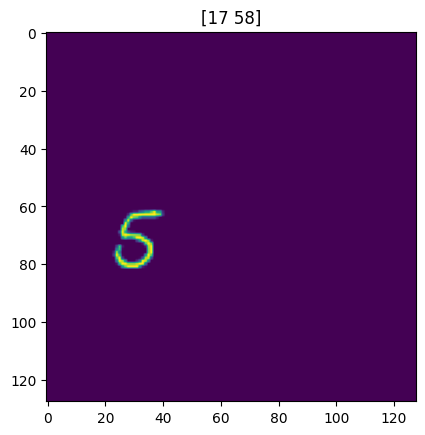

In [20]:
for a in train_coords_dataset:
    image, coords = a
    print(image.shape, coords.shape)
    plt.imshow(image[0])
    plt.title(f'{coords[0]}')

In [21]:
write_in_batches(train_dataset, 'train.tfrecord')
del train_dataset
write_in_batches(test_dataset, 'test.tfrecord')
del test_dataset
write_in_batches(train_coords_dataset, 'coords.tfrecord', True)
del train_coords_dataset
write_in_batches(test_coords_dataset, 'coords_test.tfrecord', True)
del test_coords_dataset

(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 10)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
(128, 128, 128, 1)
(128, 2)
